In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

#chnage directory C:\Users\gsent\Desktop\3rd Year Research(NOT_SURE)\Dissertation\Python Code\2nd Semester
os.chdir("C:\\Users\\gsent\\Desktop\\3rd Year Research(NOT_SURE)\\Dissertation\\Python Code\\2nd Semester")


# Load the data
data = pd.read_csv("Connectivity_Indexed.csv").dropna()
data2 = pd.read_csv('Filtered_Participant_SNP.csv')


brain_df = pd.read_csv("Connectivity_Indexed.csv")
snp_df = pd.read_csv('Filtered_Participant_SNP.csv')
snp_names = pd.read_excel('20_SNP.xlsx')

# Remove rows with NaN values
data = data.dropna()

# Ensure indices are aligned before dropping NaNs--?> 
#Combination 1.--> this was the random one selected networks + DMN 1 and 2 
#  Y = brain_df[['DMN 1 ', 'DMN 2 ','SMN 1', 'SMN 2', 'SMN 6', 'SMN 9', 'SMN 12', 'SMN 14', 'DAN 2 ', 'DAN 3', 'CN 1 ', 'CN 2 ', 'CN 4', 'CN 6', 'VN 1 ', 'VN 7', 'VN 10']]\

#combination 2 --> Elastic net regression selected network
#Y1 = brain_df[['DMN 2 ', 'SMN 8', 'VN 6', 'CN 4', 'DAN 7', 'DAN 5', 'DMN 1 ', 'CN 5', 'CN 6', 'VN 7', 'DAN 4', 'DAN 2 ', 'CN 2 ', 'SMN 2', 'DAN 6', 'VN 3', 'VN 4', 'VN 2 ', 'DAN 10', 'SMN 4']]

#combination 3 --> ML regression selected networks  --> 
#Y = brain_df[['VN 10', 'DAN 5', 'VN 6', 'DAN 10', 'CN 6', 'DAN 7', 'DAN 11', 'CN 3', 'VN 2 ', 'DAN 8', 'SMN 4', 'VN 1 ', 'SMN 8', 'DAN 2 ', 'CN 5', 'CN 2 ', 'VN 7', 'SMN 3 ', 'VN 3', 'DMN 2 ']]

#combination 4 --> CAIDE selected networks
#Y = brain_df[['DMN 2 ', 'SMN 1', 'SMN 2', 'SMN 6', 'SMN 8', 'SMN 9', 'SMN 12', 'SMN 13', 'SMN 14', 'DAN 2 ', 'DAN 3', 'CN 1 ', 'CN 2 ', 'CN 3', 'CN 4', 'CN 6', 'VN 1 ', 'VN 7', 'VN 9', 'VN 10']]

#combination --> XG boosted trees selected networks
#Y = brain_df[['CN 2 ', 'CN 5', 'DAN 7', 'VN 2 ', 'DAN 3', 'DAN 2 ', 'VN 10', 'DAN 10', 'CN 6', 'VN 9', 'SMN 3 ', 'CN 3', 'VN 4', 'VN 6', 'CN 4', 'VN 7', 'DAN 5', 'SMN 6', 'CN 1 ', 'DAN 6']]


#combination 5--> all networks 

Y1= brain_df[['DMN 1', 'DMN 2', 'DMN 3', 'DMN 4', 'SMN 1', 'SMN 2', 'SMN 3', 'SMN 4', 'SMN 5', 'SMN 6', 
              'SMN 7', 'SMN 8', 'SMN 9', 'SMN 10', 'SMN 11', 'SMN 12', 'SMN 13', 'SMN 14', 'SN 1', 'SN 2', 
              'SN 3', 'SN 4', 'SN 5', 'SN 6', 'DAN 1', 'DAN 2', 'DAN 3', 'DAN 4', 'DAN 5', 'DAN 6', 'DAN 7', 
              'DAN 8', 'DAN 9', 'DAN 10', 'DAN 11', 'CN 1', 'CN 2', 'CN 3', 'CN 4', 'CN 5', 'CN 6', 'VN 1', 
              'VN 2', 'VN 3', 'VN 4', 'VN 5', 'VN 6', 'VN 7', 'VN 8', 'VN 9', 'VN 10']]

X1 = snp_df[['rs28394864_A', 'rs602602_A', 'rs12151021_A', 'rs429358_C', 'rs1354106_G', 'rs4663105_C', 
            'rs6069737_T', 'rs679515_T', 'rs1582763_A', 'rs1532278_A', 'rs561655_G', 'rs11218343_G', 
            'rs7146179_A', 'rs12590654_A', 'rs1846190_A', 'rs187370608_A', 'rs9369716_T', 'rs7912495_G', 
            'rs7384878_C', 'rs3935067_C']]



data3 = pd.read_excel('20_SNP.xlsx')
      
# Rename SNPs in X based on data3
for i, col in enumerate(X1.columns):
    match = data3[data3['Lead Variant'].str[:6] == col[:6]]
    if not match.empty:
        X1.columns.values[i] = match['Gene'].values[0]



Shared Variance (mean R²) within each network:
DMN: 0.118
SMN: 0.114
SN: 0.054
DAN: 0.066
CN: 0.077
VN: 0.055


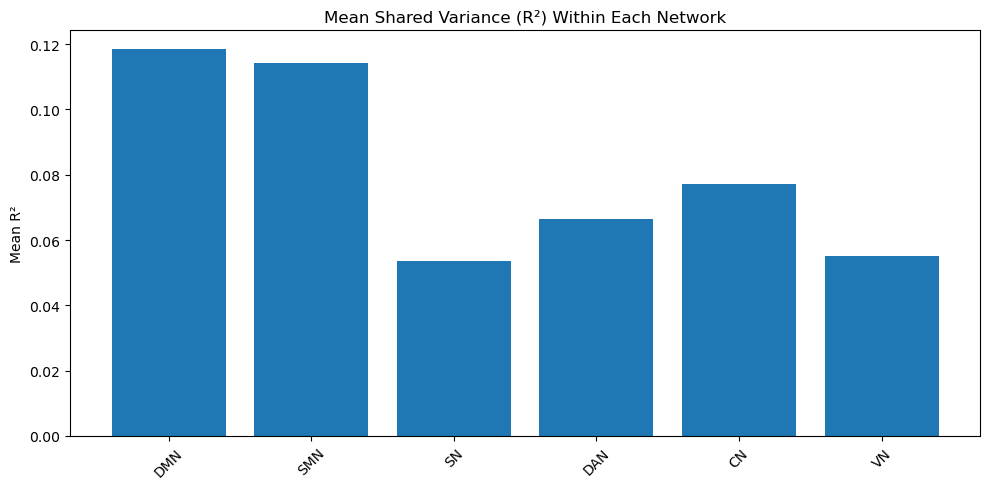

In [3]:
# Step 1: Group network features by their prefix
network_groups = {}
for col in Y1.columns:
    prefix = col.strip().split()[0]  # e.g., "DMN", "SMN", etc.
    if prefix not in network_groups:
        network_groups[prefix] = []
    network_groups[prefix].append(col)

# Step 2: Compute shared variance (mean R²) within each group
shared_variance = {}
for network, features in network_groups.items():
    if len(features) < 2:
        shared_variance[network] = np.nan  # Not enough features to compute pairwise correlation
        continue
    sub_df = Y1[features].dropna()
    corr_matrix = sub_df.corr()  # Pearson correlation
    upper_triangle_indices = np.triu_indices_from(corr_matrix, k=1)
    r_squared_values = corr_matrix.values[upper_triangle_indices] ** 2
    shared_variance[network] = np.mean(r_squared_values)

# Step 3: Print and plot results
print("Shared Variance (mean R²) within each network:")
for net, var in shared_variance.items():
    print(f"{net}: {var:.3f}")

# Optional: bar plot
plt.figure(figsize=(10, 5))
plt.bar(shared_variance.keys(), shared_variance.values())
plt.title("Mean Shared Variance (R²) Within Each Network")
plt.ylabel("Mean R²")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Total variance explained by each network:
DMN: 8.688
SMN: 22.641
SN: 11.989
DAN: 24.636
CN: 12.317
VN: 19.588


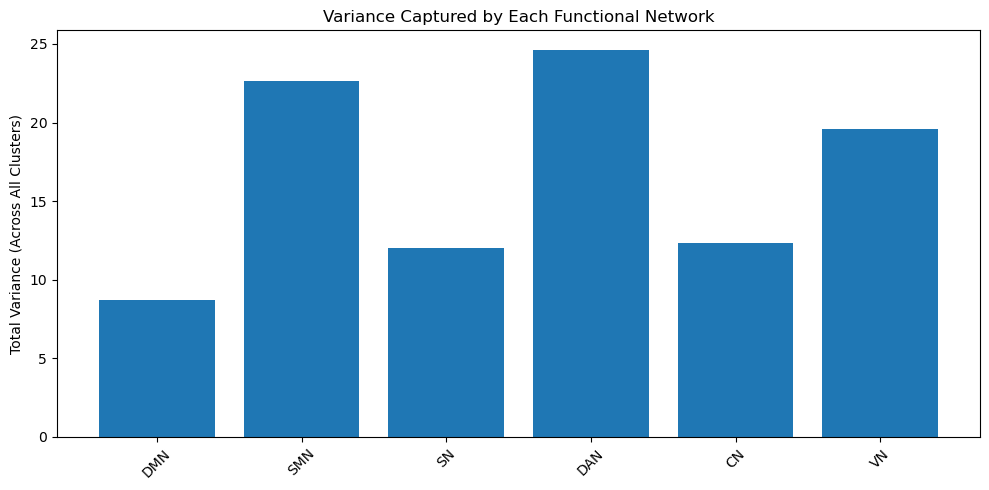

In [5]:
# Assume Y1 is your full connectivity DataFrame
network_variance = {}

for network, features in network_groups.items():  # same network_groups logic from earlier
    sub_df = Y1[features].dropna()
    total_var = np.sum(np.var(sub_df, axis=0))  # or sub_df.var().sum()
    network_variance[network] = total_var

# Print and plot
print("Total variance explained by each network:")
for net, var in network_variance.items():
    print(f"{net}: {var:.3f}")

plt.figure(figsize=(10, 5))
plt.bar(network_variance.keys(), network_variance.values())
plt.ylabel("Total Variance (Across All Clusters)")
plt.title("Variance Captured by Each Functional Network")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
#Check X and Y variables are normally distributed
X1 = X1.dropna()
Y1 = Y1.dropna()
print(X1.shape)
print(Y1.shape)

X_centered = X1 - X1.mean()
Y_centered = Y1 - Y1.mean()
X_scaled = X_centered / X1.std()
Y1_scaled = Y_centered / Y1.std()

# Check if the data is normally distributed
print("X mean:", X1.mean())
print("X std:", X1.std())
print("Y mean:", Y1.mean())
print("Y std:", Y1.std())





(482, 20)
(482, 51)
X mean: ABI3             0.902490
ADAM10           0.574689
ABCA7            0.665975
APOE             0.433610
CD33             0.680498
BIN1             0.829876
CASS4            0.149378
CR1              0.334025
MS4A4A           0.726141
CLU              0.765560
PICALM           0.672199
SORL1            0.070539
FERMT2           0.213693
RIN3             0.709544
HLA-DRB1         0.580913
TREM2            0.018672
CD2AP            0.553942
USP6NL/ECHDC3    0.941909
ZCWPW1/NYAP1     0.599585
EPHA1-AS1        0.780083
dtype: float64
X std: ABI3             0.689115
ADAM10           0.650941
ABCA7            0.678175
APOE             0.595156
CD33             0.665135
BIN1             0.709381
CASS4            0.368299
CR1              0.522313
MS4A4A           0.666780
CLU              0.692262
PICALM           0.664214
SORL1            0.256320
FERMT2           0.444391
RIN3             0.690500
HLA-DRB1         0.675291
TREM2            0.135505
CD2AP         

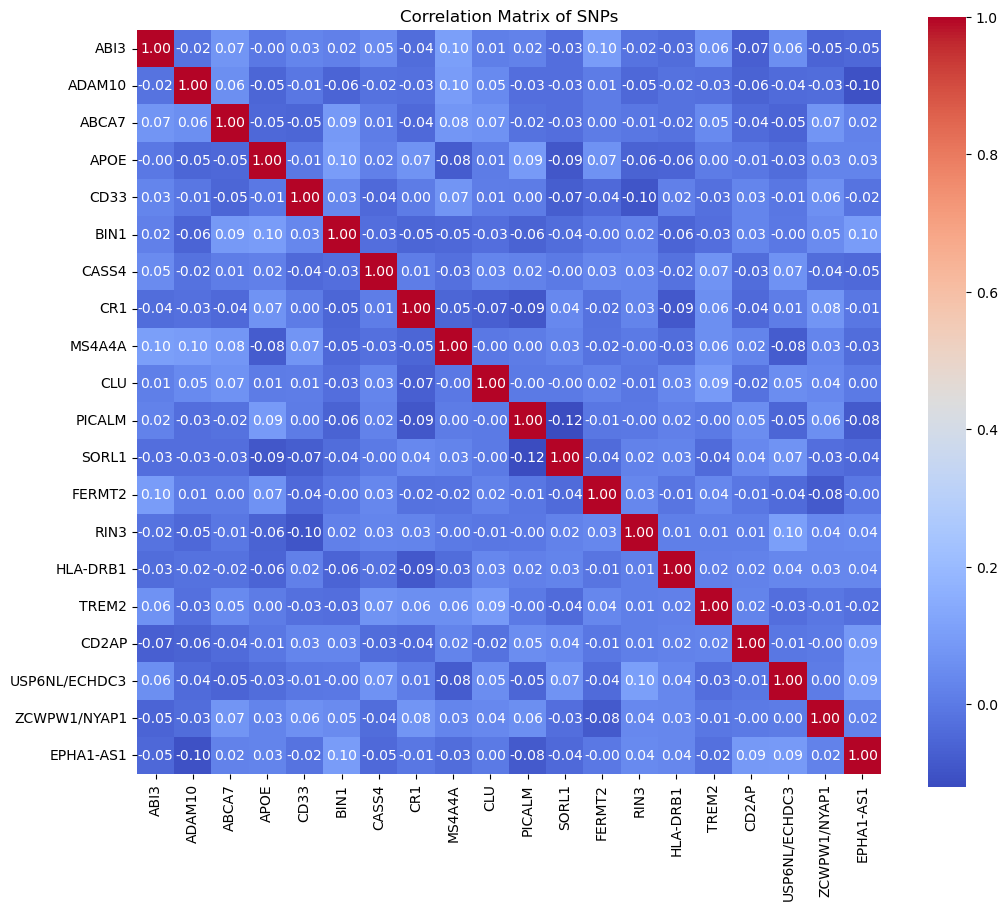

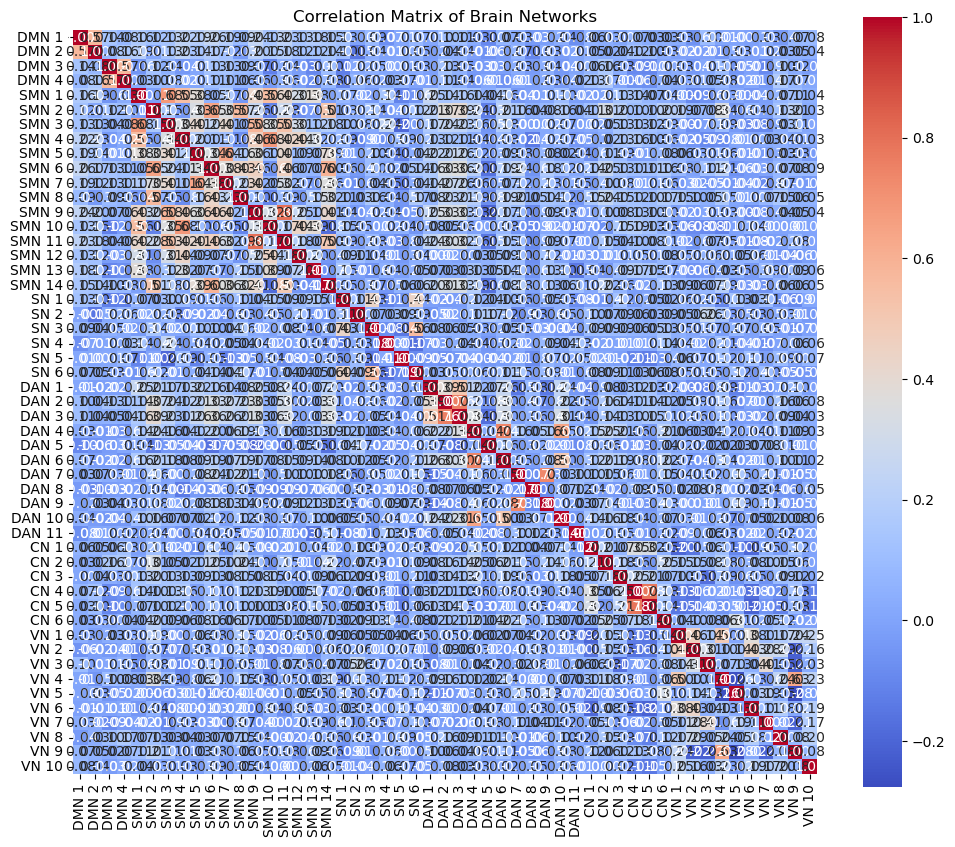

          feature       VIF
0            ABI3  1.053839
1          ADAM10  1.043886
2           ABCA7  1.049669
3            APOE  1.057104
4            CD33  1.038781
5            BIN1  1.054330
6           CASS4  1.022418
7             CR1  1.056726
8          MS4A4A  1.058841
9             CLU  1.030768
10         PICALM  1.058770
11          SORL1  1.050430
12         FERMT2  1.030753
13           RIN3  1.035352
14       HLA-DRB1  1.025787
15          TREM2  1.035927
16          CD2AP  1.031037
17  USP6NL/ECHDC3  1.055706
18   ZCWPW1/NYAP1  1.044024
19      EPHA1-AS1  1.056433
   feature       VIF
0    DMN 1  1.858248
1    DMN 2  1.783965
2    DMN 3  1.672878
3    DMN 4  1.686105
4    SMN 1  3.659602
5    SMN 2  2.879303
6    SMN 3  3.347000
7    SMN 4  2.917571
8    SMN 5  2.377321
9    SMN 6  2.753061
10   SMN 7  2.425913
11   SMN 8  1.867138
12   SMN 9  4.113024
13  SMN 10  2.913035
14  SMN 11  4.092443
15  SMN 12  1.529515
16  SMN 13  1.636028
17  SMN 14  2.352451
18    SN 1  1

In [17]:
# Check for multicollinearity in X
correlation_matrix = X_scaled.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title("Correlation Matrix of SNPs")
plt.show()


# Check for multicollinearity in Y
correlation_matrix2 = Y1_scaled.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title("Correlation Matrix of Brain Networks")
plt.show()

# Assuming your connectivity data is a DataFrame called "X"
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

print(vif_data)

# Assuming your connectivity data is a DataFrame called "X"
vif_data = pd.DataFrame()
vif_data["feature"] = Y1_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(Y1_scaled.values, i) for i in range(Y1_scaled.shape[1])]

print(vif_data)





In [19]:
# Standardize X1 before computing VIF
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Display VIF
print(vif_data.sort_values(by="VIF", ascending=False))


          Feature       VIF
8          MS4A4A  1.058841
10         PICALM  1.058770
3            APOE  1.057104
7             CR1  1.056726
19      EPHA1-AS1  1.056433
17  USP6NL/ECHDC3  1.055706
5            BIN1  1.054330
0            ABI3  1.053839
11          SORL1  1.050430
2           ABCA7  1.049669
18   ZCWPW1/NYAP1  1.044024
1          ADAM10  1.043886
4            CD33  1.038781
15          TREM2  1.035927
13           RIN3  1.035352
16          CD2AP  1.031037
9             CLU  1.030768
12         FERMT2  1.030753
14       HLA-DRB1  1.025787
6           CASS4  1.022418


1. remove networks not correlated 
2. Print top 20 networks multicolinear 

Highly correlated feature pairs (|r| ≥ 0.60):
     Feature1 Feature2  Correlation
535     SMN 9   SMN 11     0.797986
1197     CN 4     CN 5     0.783433
950     DAN 2    DAN 3     0.756843
1000    DAN 4    DAN 6     0.739849
1066    DAN 7    DAN 9     0.730823
195     SMN 1    SMN 3     0.683802
334     SMN 4   SMN 10     0.681343
243     SMN 2    SMN 6     0.649994
1004    DAN 4   DAN 10     0.645042
373     SMN 5    SMN 7     0.637132
1258     VN 4     VN 9     0.633941


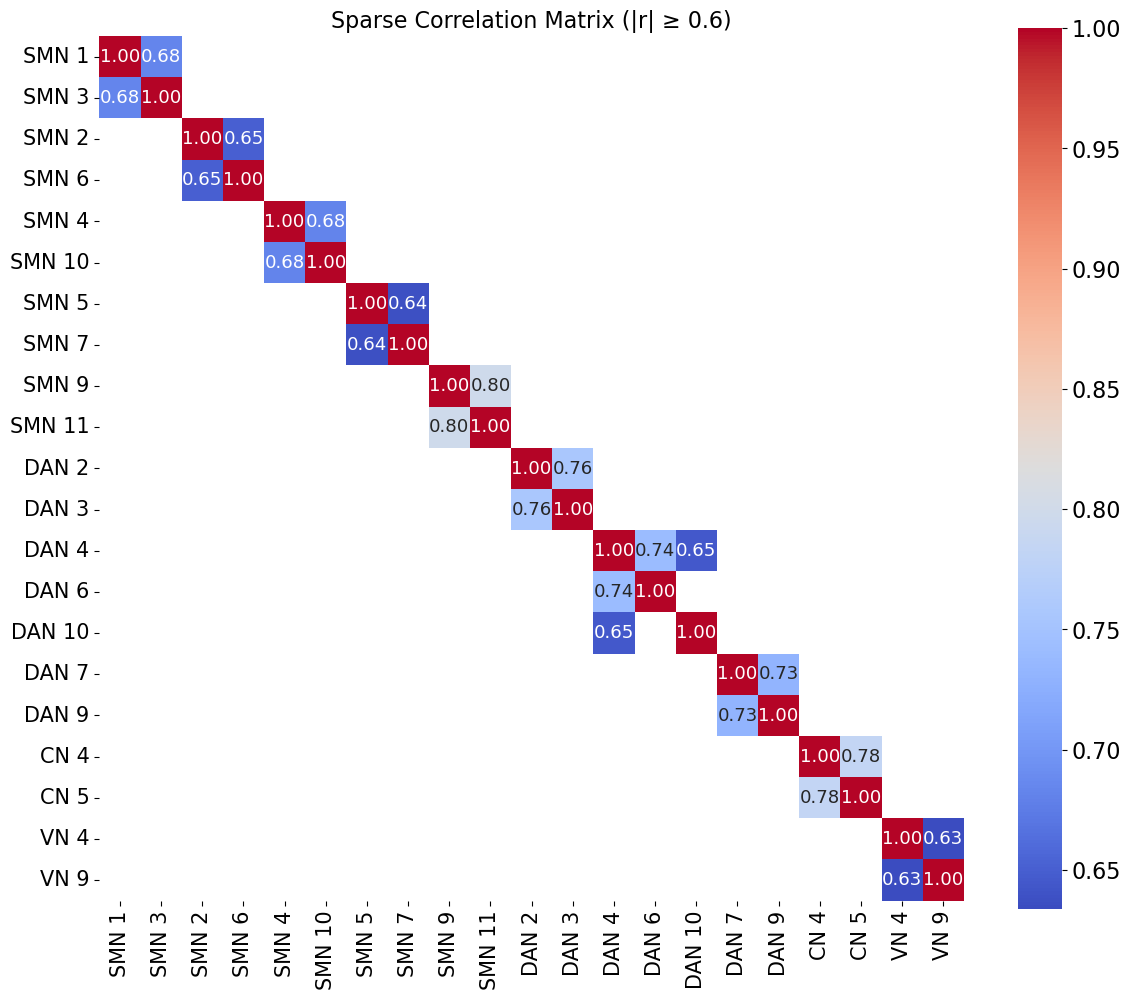

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Make printed DataFrame output more compact
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Step 1: Compute correlation matrix
corr_matrix = Y1_scaled.corr()
threshold = 0.6  # Adjust as needed

# Step 2: Get pairs of variables with high correlation (off-diagonal)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() >= threshold]

# Step 3: Print the strongly correlated feature pairs
print("Highly correlated feature pairs (|r| ≥ {:.2f}):".format(threshold))
print(high_corr_pairs.sort_values(by='Correlation', ascending=False))

# Step 4: Filter the correlation matrix to include only those involved in strong correlations
strong_features = pd.unique(high_corr_pairs[['Feature1', 'Feature2']].values.ravel())
filtered_corr = corr_matrix.loc[strong_features, strong_features]

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    mask=(filtered_corr.abs() < threshold),
    annot_kws={"size": 13}
)

# Access the colorbar and increase its tick label size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Adjust the size here

plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title(f"Sparse Correlation Matrix (|r| ≥ {threshold})", fontsize=16)
plt.tight_layout()
plt.show()




Normality tests for SNPs (X):

Column: ABI3
Shapiro-Wilk Test: Stat=0.802, p=0.000
Does NOT look Gaussian (reject H0)
D'Agostino-Pearson Test: Stat=59.392, p=0.000
Does NOT look Gaussian (reject H0)
Anderson-Darling Test: Stat=41.916
At 15.0% significance level: Does NOT look Gaussian
At 10.0% significance level: Does NOT look Gaussian
At 5.0% significance level: Does NOT look Gaussian
At 2.5% significance level: Does NOT look Gaussian
At 1.0% significance level: Does NOT look Gaussian

Column: ADAM10
Shapiro-Wilk Test: Stat=0.741, p=0.000
Does NOT look Gaussian (reject H0)
D'Agostino-Pearson Test: Stat=44.393, p=0.000
Does NOT look Gaussian (reject H0)
Anderson-Darling Test: Stat=55.339
At 15.0% significance level: Does NOT look Gaussian
At 10.0% significance level: Does NOT look Gaussian
At 5.0% significance level: Does NOT look Gaussian
At 2.5% significance level: Does NOT look Gaussian
At 1.0% significance level: Does NOT look Gaussian

Column: ABCA7
Shapiro-Wilk Test: Stat=0.769,

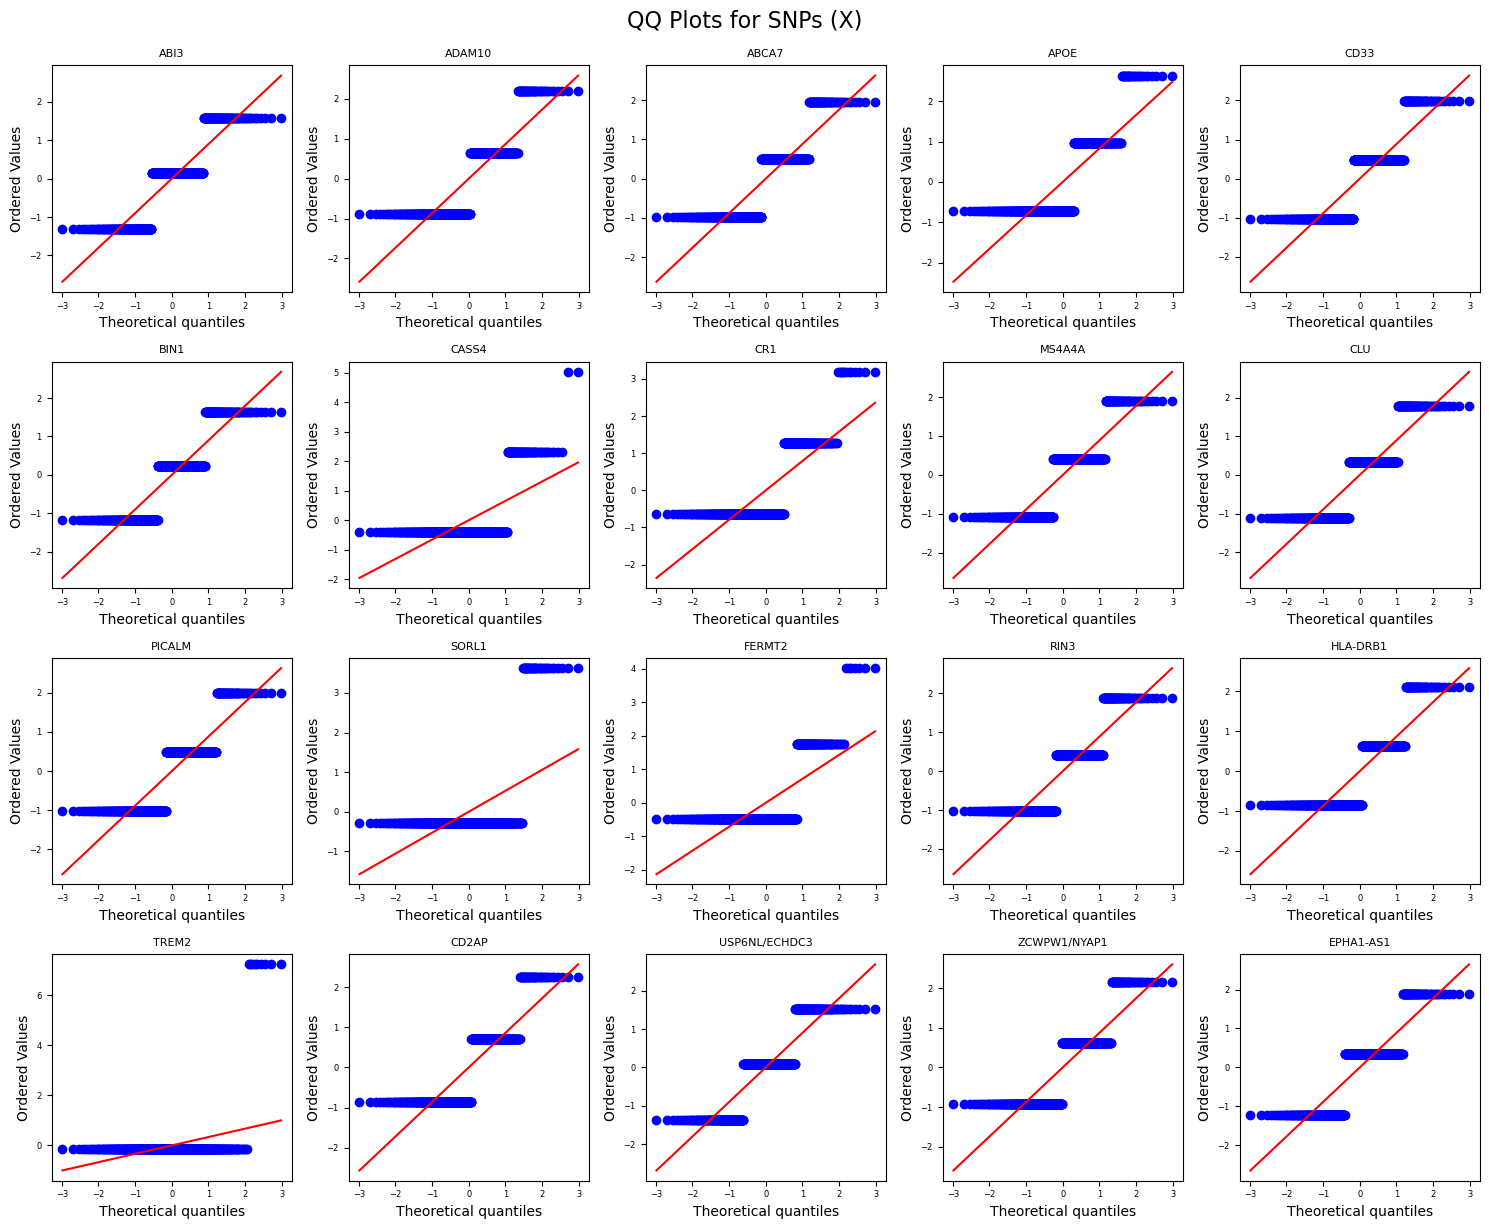

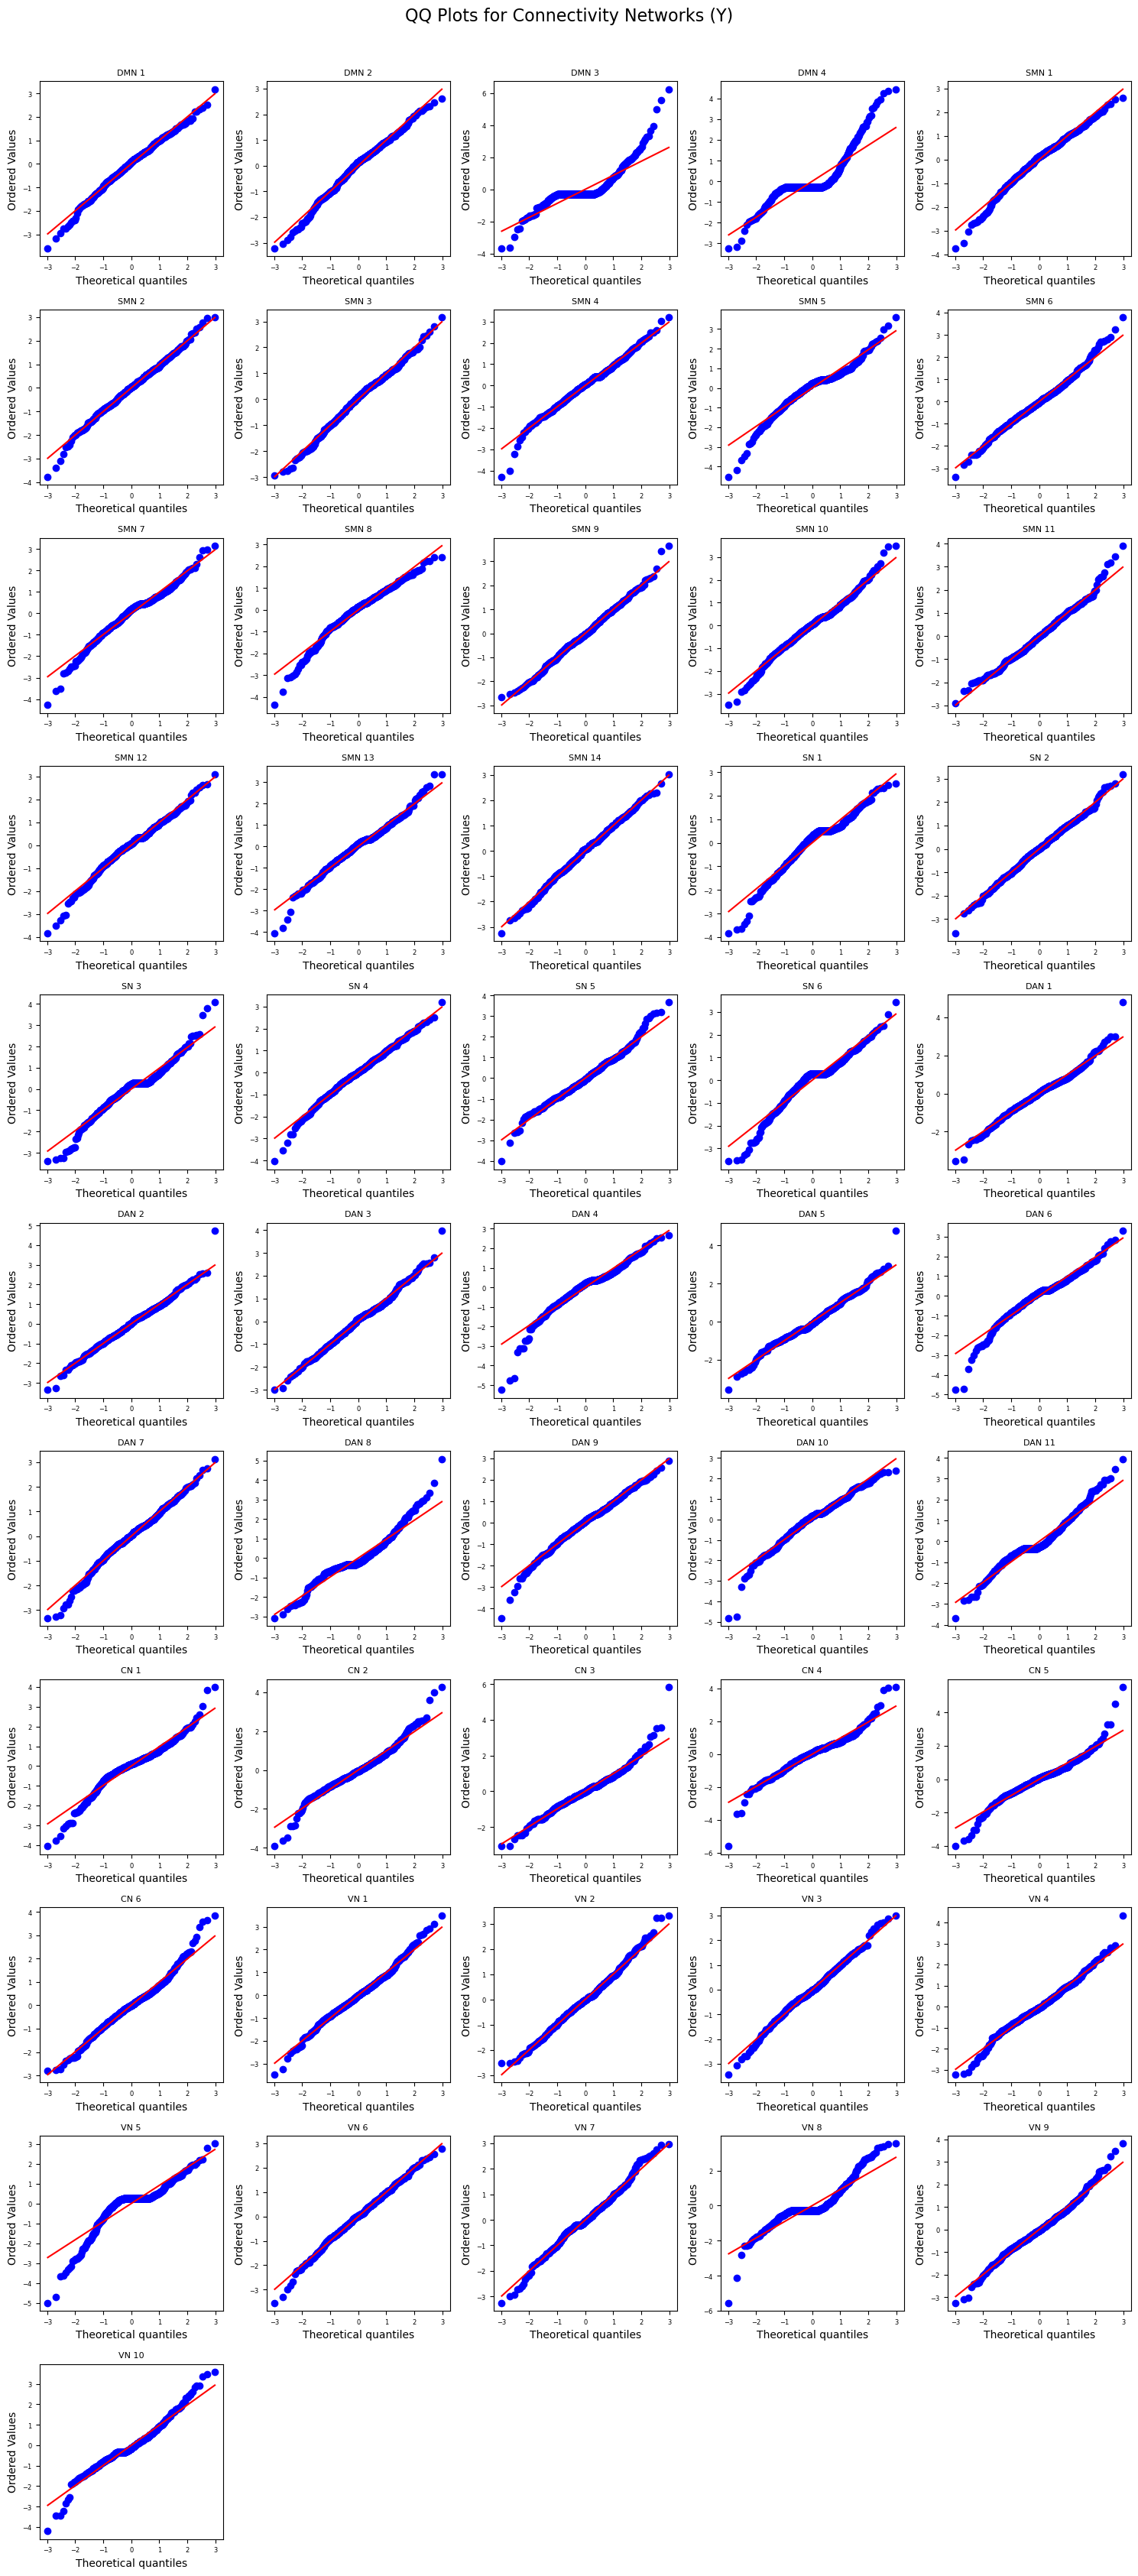

In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq_grid(df, name, n_cols=5):
    n_vars = df.shape[1]
    n_rows = (n_vars + n_cols - 1) // n_cols  # Round up
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    for i, col in enumerate(df.columns):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx]
        stats.probplot(df[col], dist="norm", plot=ax)
        ax.set_title(col, fontsize=8)
        ax.tick_params(labelsize=6)
    
    # Turn off empty subplots if any
    for j in range(i+1, n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.suptitle(f'QQ Plots for {name}', y=1.02, fontsize=16)
    plt.show()

# Call function for X and Y
plot_qq_grid(X_scaled, "SNPs (X)")
plot_qq_grid(Y1_scaled, "Connectivity Networks (Y)")


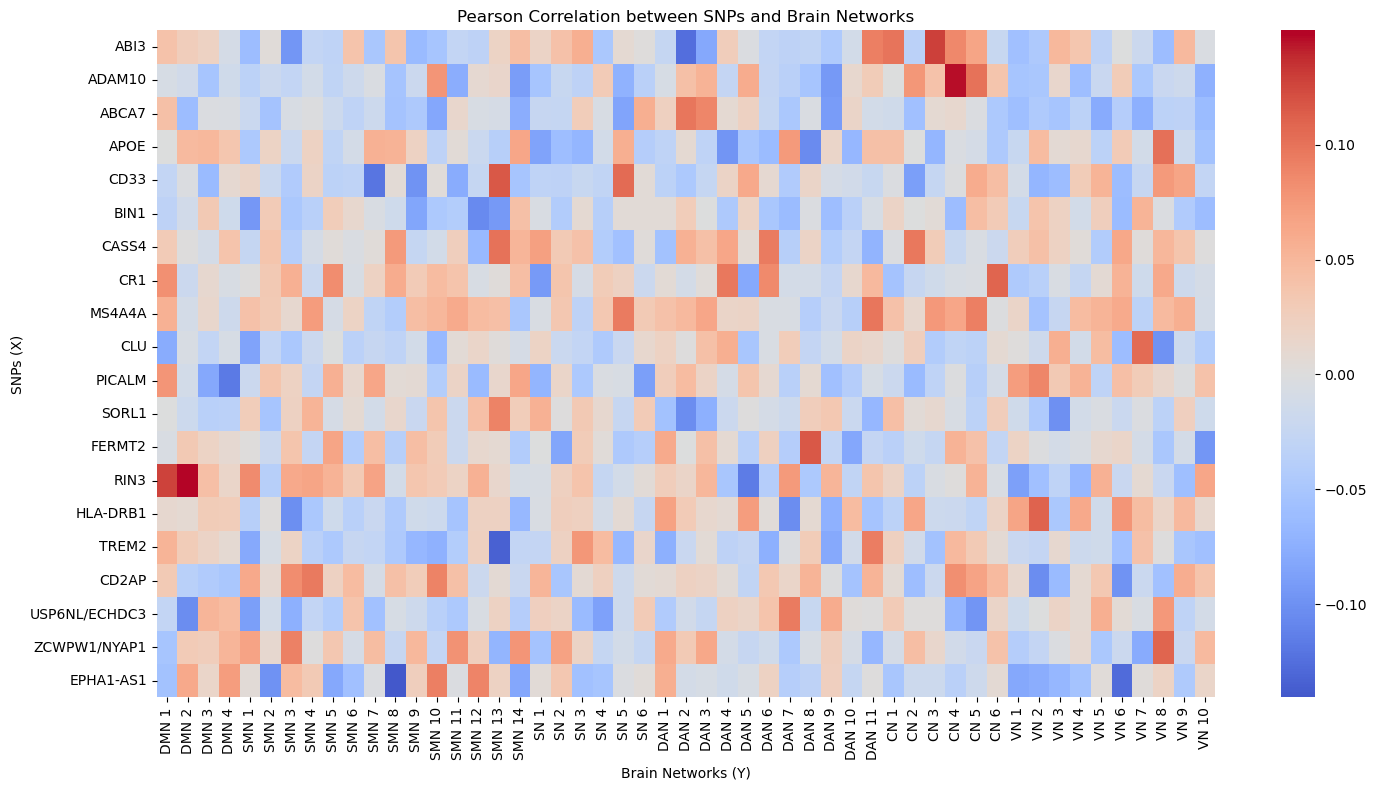


Top 10 SNP-Brain Network Associations (by |correlation|):
                  Correlation   p-value
DMN 2  RIN3          0.149703  0.000978
CN 4   ADAM10        0.145713  0.001337
SMN 8  EPHA1-AS1    -0.140499  0.001989
SMN 13 TREM2        -0.134824  0.003018
CN 3   ABI3          0.128438  0.004740
VN 6   EPHA1-AS1    -0.127513  0.005053
DMN 1  RIN3          0.127467  0.005068
DAN 2  ABI3         -0.124663  0.006134
SMN 7  CD33         -0.120778  0.007944
DMN 4  PICALM       -0.117272  0.009970


In [ ]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize DataFrames to store correlation coefficients and p-values
correlation_matrix = pd.DataFrame(index=X_scaled.columns, columns=Y1_scaled.columns, dtype=float)
pvalue_matrix = pd.DataFrame(index=X_scaled.columns, columns=Y1_scaled.columns, dtype=float)

# Loop through each SNP (X) and brain network (Y)
for x_var in X_scaled.columns:
    for y_var in Y1_scaled.columns:
        r, p = pearsonr(X_scaled[x_var], Y1_scaled[y_var])
        correlation_matrix.loc[x_var, y_var] = r
        pvalue_matrix.loc[x_var, y_var] = p

# Heatmap of correlations
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Pearson Correlation between SNPs and Brain Networks")
plt.xlabel("Brain Networks (Y)")
plt.ylabel("SNPs (X)")
plt.tight_layout()
plt.show()

# Unstack and combine r-values and p-values for top results
correlations_unstacked = correlation_matrix.unstack()
pvalues_unstacked = pvalue_matrix.unstack()

# Combine into a single DataFrame
combined_df = pd.DataFrame({
    'Correlation': correlations_unstacked,
    'p-value': pvalues_unstacked
})

# Sort by absolute value of correlation to get strongest relationships
combined_df['abs_corr'] = combined_df['Correlation'].abs()
top_10 = combined_df.sort_values(by='abs_corr', ascending=False).drop('abs_corr', axis=1).head(10)

# Show top 10 SNP-network associations with p-values
print("\nTop 10 SNP-Brain Network Associations (by |correlation|):")
print(top_10)

# Optional: Save to CSV
top_10.to_csv("Top10_SNP_Network_Associations_with_pvals.csv")



In [ ]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

# Initialize lists to collect results
results = []

# Loop through each SNP and brain network
for x_var in X_scaled.columns:
    for y_var in Y1_scaled.columns:
        # Pearson
        r_p, p_p = pearsonr(X_scaled[x_var], Y1_scaled[y_var])
        # Spearman
        r_s, p_s = spearmanr(X_scaled[x_var], Y1_scaled[y_var])
        
        results.append({
            'SNP': x_var,
            'Network': y_var.strip(),  # clean any stray spaces
            'Pearson_r': r_p,
            'Pearson_p': p_p,
            'Spearman_r': r_s,
            'Spearman_p': p_s
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# FDR correction
results_df['Pearson_fdr'] = multipletests(results_df['Pearson_p'], method='fdr_bh')[1]
results_df['Spearman_fdr'] = multipletests(results_df['Spearman_p'], method='fdr_bh')[1]

# Optional: Flag significant ones (FDR < 0.05)
results_df['Significant_Pearson'] = results_df['Pearson_fdr'] < 0.05
results_df['Significant_Spearman'] = results_df['Spearman_fdr'] < 0.05

# Sort by absolute correlation
results_df['abs_Pearson_r'] = results_df['Pearson_r'].abs()
results_df['abs_Spearman_r'] = results_df['Spearman_r'].abs()

# Get top 15 by absolute Pearson correlation
top_results = results_df.sort_values(by='abs_Pearson_r', ascending=False).drop(columns=['abs_Pearson_r', 'abs_Spearman_r']).head(15)

# Show results
print("\nTop 15 SNP-Network Associations (by |Pearson r| with FDR correction):")
print(top_results[['SNP', 'Network', 'Pearson_r', 'Pearson_p', 'Pearson_fdr', 'Significant_Pearson',
                   'Spearman_r', 'Spearman_p', 'Spearman_fdr', 'Significant_Spearman']])

# Optional: Save to CSV
top_results.to_csv("Top15_SNP_Network_Associations_with_FDR.csv", index=False)



Top 15 SNP-Network Associations (by |Pearson r| with FDR correction):
            SNP Network  Pearson_r  Pearson_p  Pearson_fdr  Significant_Pearson  Spearman_r  Spearman_p  Spearman_fdr  Significant_Spearman
664        RIN3   DMN 2   0.149703   0.000978     0.676145                False    0.137640    0.002459      0.791828                 False
89       ADAM10    CN 4   0.145713   0.001337     0.676145                False    0.101235    0.026249      0.832192                 False
980   EPHA1-AS1   SMN 8  -0.140499   0.001989     0.676145                False   -0.107047    0.018732      0.811087                 False
781       TREM2  SMN 13  -0.134824   0.003018     0.738538                False   -0.113903    0.012338      0.791828                 False
37         ABI3    CN 3   0.128438   0.004740     0.738538                False    0.114776    0.011681      0.791828                 False
1015  EPHA1-AS1    VN 6  -0.127513   0.005053     0.738538                False   -0.1215

How is it calculating this? check last convo with CHATGPT 

In [ ]:
# Correct: SNPs as X (predictors), Connectivity as Y (responses)

X1 = snp_df[['rs28394864_A', 'rs602602_A', 'rs12151021_A', 'rs429358_C', 'rs1354106_G', 'rs4663105_C', 
            'rs6069737_T', 'rs679515_T', 'rs1582763_A', 'rs1532278_A', 'rs561655_G', 'rs11218343_G', 
            'rs7146179_A', 'rs12590654_A', 'rs1846190_A', 'rs187370608_A', 'rs9369716_T', 'rs7912495_G', 
            'rs7384878_C', 'rs3935067_C']]

Y1 = brain_df [['DMN 1 ', 'DMN 2 ', 'SMN 1', 'SMN 2', 'SMN 3 ', 'SMN 4', 'SMN 5', 'SMN 6', 'SMN 7', 'SMN 8', 'SMN 9','DAN 2 ', 'DAN 3', 'DAN 4', 'DAN 5', 'DAN 6', 'DAN 7', 'DAN 8', 'DAN 10', 'DAN 11', 'CN 1 ', 'CN 2 ', 'CN 3','CN 4', 'CN 5', 'CN 6', 'VN 1 ', 'VN 2 ', 'VN 3', 'VN 4', 'VN 6', 'VN 7', 'VN 9', 'VN 10']]

# Make sure to scale again if needed
X_scaled = (X1 - X1.mean()) / X1.std()
Y1_scaled = (Y1 - Y1.mean()) / Y1.std()

# Rename SNPs in X based on data3
for i, col in enumerate(X1.columns):
    match = data3[data3['Lead Variant'].str[:6] == col[:6]]
    if not match.empty:
        X1.columns.values[i] = match['Gene'].values[0]

# Now do the multivariate regression correctly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize a dictionary to store results
results = {}

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y1_scaled, test_size=0.5, random_state=42)

# Initialize the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Initialize a dictionary to store results
results = {}

# Now, calculate R² and MSE **for each brain network separately**
for i, col in enumerate(Y1_scaled.columns):
    mse = mean_squared_error(Y_test.iloc[:, i], Y_pred[:, i])
    r2 = r2_score(Y_test.iloc[:, i], Y_pred[:, i])
    results[col] = {'MSE': mse, 'R^2': r2}

# Convert to DataFrame and transpose so 'R^2' becomes a column
results_df = pd.DataFrame(results).T

# Compute absolute R^2 and sort
results_df['abs_R^2'] = results_df['R^2'].abs()
results_df = results_df.sort_values(by='abs_R^2', ascending=False)

print(results_df)

# Optional: Save
results_df.to_csv("Multivariate_Regression_Results_Correct.csv", index=True)


             MSE       R^2   abs_R^2
SMN 4   1.242336 -0.235853  0.235853
CN 2    1.088164 -0.230756  0.230756
DMN 1   1.116358 -0.213256  0.213256
SMN 9   1.269284 -0.203119  0.203119
DAN 5   1.110374 -0.180776  0.180776
DAN 4   1.012345 -0.175657  0.175657
DAN 6   1.050966 -0.157072  0.157072
VN 1    1.138460 -0.151235  0.151235
DMN 2   1.043216 -0.146113  0.146113
VN 7    1.153819 -0.130318  0.130318
CN 3    1.127186 -0.126202  0.126202
SMN 1   1.286319 -0.116014  0.116014
SMN 7   1.220453 -0.103149  0.103149
VN 3    1.089000 -0.101440  0.101440
DAN 2   1.106934 -0.099397  0.099397
VN 4    1.101928 -0.091564  0.091564
DAN 7   0.966404 -0.088504  0.088504
CN 6    0.952290 -0.086021  0.086021
SMN 5   1.275033 -0.085871  0.085871
SMN 3   1.209308 -0.084774  0.084774
DAN 10  1.159661 -0.083997  0.083997
SMN 6   1.118434 -0.080753  0.080753
CN 4    1.134956 -0.068597  0.068597
VN 2    0.976060 -0.065036  0.065036
CN 1    1.162786 -0.064424  0.064424
DAN 3   1.121626 -0.062321  0.062321
V

In [ ]:

#for DMN 2 see which SNPs are most important
# After fitting the model
# Get the coefficients
coefs = pd.DataFrame(model.coef_, columns=X_scaled.columns, index=Y1_scaled.columns)

# Now look specifically at DMN 2
dmn2_coefs = coefs.loc['DMN 2 '].sort_values(ascending=False)

# Print top positive and negative associations
print("Top positive associations with DMN 2:")
print(dmn2_coefs.head(5))

print("\nTop negative associations with DMN 2:")
print(dmn2_coefs.tail(5))



Top positive associations with DMN 2:
RIN3            0.236263
EPHA1-AS1       0.138860
APOE            0.107795
ZCWPW1/NYAP1    0.094165
CD2AP           0.042750
Name: DMN 2 , dtype: float64

Top negative associations with DMN 2:
CD33            -0.049888
ABCA7           -0.062277
BIN1            -0.074515
MS4A4A          -0.088999
USP6NL/ECHDC3   -0.124390
Name: DMN 2 , dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

# Scale predictors and responses
X_scaled = (X1 - X1.mean()) / X1.std()
Y1_scaled = (Y1 - Y1.mean()) / Y1.std()

# Rename SNPs in X based on data3
for i, col in enumerate(X1.columns):
    match = data3[data3['Lead Variant'].str[:6] == col[:6]]
    if not match.empty:
        X1.columns.values[i] = match['Gene'].values[0]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y1_scaled, test_size=0.5, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Collect metrics
results = {}
for i, col in enumerate(Y1_scaled.columns):
    y_true = Y_test.iloc[:, i]
    y_pred = Y_pred[:, i]
    
    mse = mean_squared_error(y_true, y_pred)
    r, p_value = pearsonr(y_true, y_pred)
    
    results[col.strip()] = {
        'MSE': mse,
        'Pearson_r': r,
        'abs_r': abs(r),
        'p_value': p_value
    }

# Create DataFrame
results_df = pd.DataFrame(results).T

# Bonferroni correction
results_df['p_bonferroni'] = np.minimum(results_df['p_value'] * len(results_df), 1.0)

# Sort by absolute correlation
results_df = results_df.sort_values(by='MSE', ascending=True)

# Show and save results
print(results_df)
results_df.to_csv("Multivariate_Pearson_Results.csv", index=True)


             MSE  Pearson_r     abs_r   p_value  p_bonferroni
DMN 4   0.897173   0.040007  0.040007  0.536515      1.000000
VN 6    0.918642   0.120504  0.120504  0.061788      1.000000
SMN 8   0.940580   0.087627  0.087627  0.175139      1.000000
CN 6    0.952290   0.004125  0.004125  0.949211      1.000000
DAN 7   0.966404   0.043413  0.043413  0.502375      1.000000
VN 2    0.976060   0.109638  0.109638  0.089450      1.000000
SN 6    0.979589  -0.187989  0.187989  0.003397      0.173223
DAN 4   1.012345  -0.053917  0.053917  0.404695      1.000000
VN 8    1.024459   0.070939  0.070939  0.272677      1.000000
DMN 2   1.043216   0.026054  0.026054  0.687364      1.000000
DAN 9   1.047970   0.005868  0.005868  0.927788      1.000000
DAN 6   1.050966  -0.047699  0.047699  0.461086      1.000000
SMN 13  1.055960   0.028319  0.028319  0.661794      1.000000
DAN 11  1.056328   0.091281  0.091281  0.157761      1.000000
DAN 8   1.056881   0.060841  0.060841  0.346977      1.000000
SMN 12  

In [ ]:
#Multitask Lasso 

